<a href="https://colab.research.google.com/github/aTrotier/COURS_RECO_BART/blob/main/cours_bart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Dans ce cours nous utiliserons [BART](https://mrirecon.github.io/bart/) qui est une librairie de fonction permettant de reconstruire les données IRM

La première étape et d'installer BART dans google colab : https://colab.research.google.com/

# Installation librairie

In [ ]:
!apt-get -qq install -y  gcc make libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev gfortran

# Installation de BART à partir de github

In [4]:
!git clone https://github.com/mrirecon/bart

Cloning into 'bart'...
remote: Enumerating objects: 12253, done.
remote: Counting objects: 100% (488/488), done.
remote: Compressing objects: 100% (298/298), done.
remote: Total 12253 (delta 275), reused 307 (delta 189), pack-reused 11765
Receiving objects: 100% (12253/12253), 8.23 MiB | 15.30 MiB/s, done.
Resolving deltas: 100% (8886/8886), done.


Checkout vers version 0.7



In [25]:
cd bart

[Errno 2] No such file or directory: 'bart'
/content/bart


In [26]:
!git checkout v0.7.00

Note: checking out 'v0.7.00'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at d1b0e57 bump version


**Compilation**

In [ ]:
!PARALLEL=1 make

In [28]:
!make install

make MAKESTAGE=2 install
make[1]: Entering directory '/content/bart'
install -d //usr/local//bin/
install bart //usr/local//bin/
install -d //usr/local//share/doc/bart/
install /content/bart/doc/*.txt /content/bart/README //usr/local//share/doc/bart/
install -d //usr/local//lib/bart/commands/
make[1]: Leaving directory '/content/bart'
install -d //usr/local//bin/
install bart //usr/local//bin/
install -d //usr/local//share/doc/bart/
install /content/bart/doc/*.txt /content/bart/README //usr/local//share/doc/bart/
install -d //usr/local//lib/bart/commands/


In [29]:
!bart

BART. Available commands are:
avg         bench       bin         bitmask     cabs        caldir      
calmat      carg        casorati    cc          ccapply     cdf97       
circshift   conj        conv        conway      copy        cpyphs      
creal       crop        delta       ecalib      ecaltwo     estdelay    
estdims     estshift    estvar      extract     fakeksp     fft         
fftmod      fftrot      fftshift    filter      flatten     flip        
fmac        homodyne    index       invert      itsense     join        
looklocker  lrmatrix    mandelbrot  mip         moba        mobafit     
nlinv       noise       normalize   nrmse       nufft       ones        
pattern     phantom     pics        pocsense    poisson     pol2mask    
poly        repmat      reshape     resize      rmfreq      rof         
roistat     rss         rtnlinv     sake        saxpy       scale       
sdot        show        signal      slice       spow        sqpics      
squeeze     ssa      

# Test utilisation BART avec Python

Préparation des fonctions pour être utilisées avec python

In [30]:
import os
import sys
import numpy as np

os.environ['TOOLBOX_PATH'] = '/content/bart'
path = os.environ["TOOLBOX_PATH"] + "/python/"
sys.path.append(path)

from bart import bart
import cfl

import matplotlib.pyplot as plt
%matplotlib inline

Generate a phantom with BART and plot the image

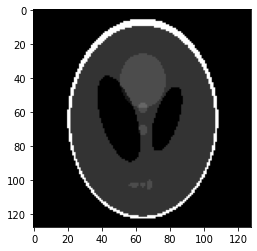

In [31]:
x = bart(1, 'phantom')
plt.figure()
plt.imshow(abs(x), cmap='gray')

# Utilisation bart

BART s'utilise en ligne de commande mais peut être utilisé gâce à un wrapper python (ce que l'on fera dans la suite de ce cours)

In [32]:
!bart phantom -h

Usage: phantom [-s d] [-S d] [-k] [-t <string>] [-G ...] [-T ...] [-N d] [-B ...] [-x d] [-g d] [-3] [-b] [-r d] <output>

Image and k-space domain phantoms.

-s nc      	nc sensitivities
-S nc      	Output nc sensitivities
-k		k-space
-t file      	trajectory
-G		geometric object phantom
-T		tubes phantom
-N num      	Random tubes phantom and number
-B		BART logo
-x n      	dimensions in y and z
-g n=1,2      	select geometry for object phantom
-3		3D
-b		basis functions for geometry
-r seed      	random seed initialization
-h		help


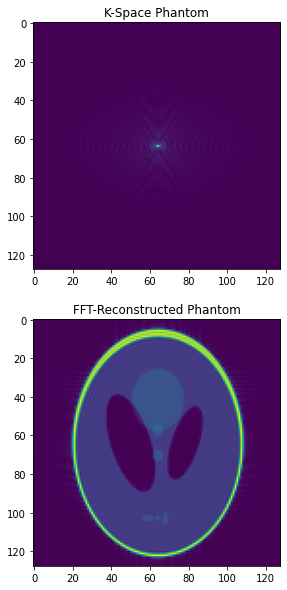

In [33]:
# Generating a k-space phantom and applying an inverse FFT.
shepp_kspace = bart(1, "phantom -k -x 128")
shepp_fft = bart(1, "fft -i 3", shepp_kspace)

fig, ax = plt.subplots(nrows=2, figsize=(6, 10))
ax[0].set_title("K-Space Phantom")
ax[0].imshow(abs(shepp_kspace))

ax[1].set_title("FFT-Reconstructed Phantom")
ax[1].imshow(abs(shepp_fft))

# Génération d'un mask pour sous-échantillonner dans une direction

(128, 128)

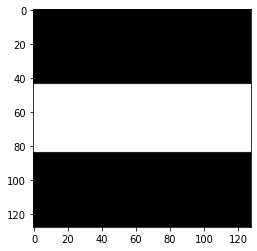

In [34]:
display(np.shape(shepp_kspace))

# mask pour garder que les lignes centrales du kspace
mask = np.zeros(np.shape(shepp_kspace))

kx1 = 44
kx2 = 84
mask[kx1:kx2,:]=np.ones(np.shape(mask[kx1:kx2,:]))

plt.figure()
plt.imshow(abs(mask), cmap='gray')

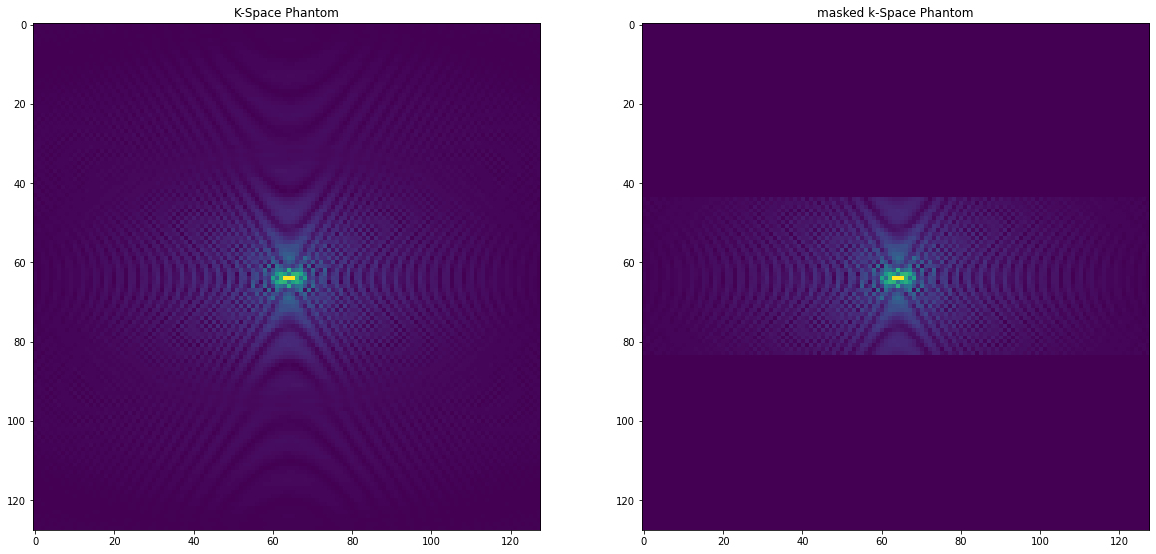

In [35]:
shepp_kspace_u = shepp_kspace * mask;

fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
ax[0].set_title("K-Space Phantom")
ax[0].imshow(abs(shepp_kspace),vmin=0, vmax=0.03)

ax[1].set_title("masked k-Space Phantom")
ax[1].imshow(abs(shepp_kspace_u),vmin=0, vmax=0.03)

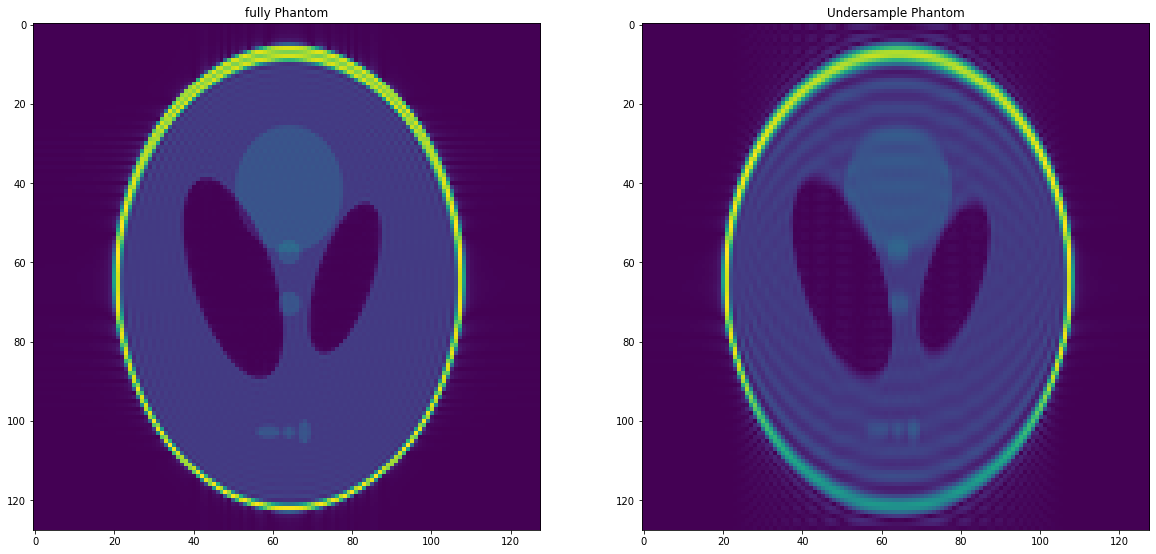

In [36]:
shepp_fft_u = bart(1, "fft -i 3", shepp_kspace_u)

fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
ax[0].set_title("fully Phantom")
ax[0].imshow(abs(shepp_fft))

ax[1].set_title("Undersample Phantom")
ax[1].imshow(abs(shepp_fft_u))

# Zero-filling reconstruction

(256, 256)

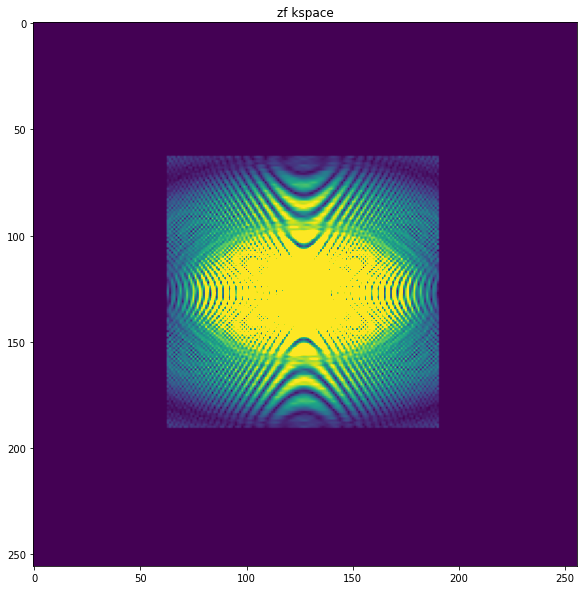

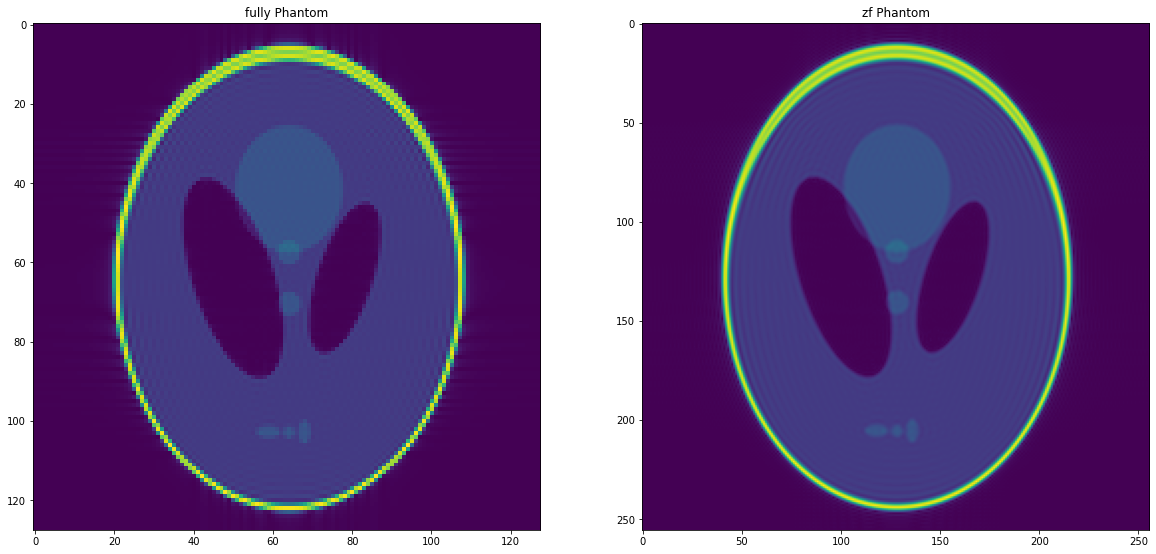

In [37]:
shepp_kspace_zf = np.zeros((256,256),dtype=complex)
display(np.shape(shepp_kspace_zf))

shepp_kspace_zf[63:63+128,63:63+128]=shepp_kspace

shepp_fft_zf = bart(1, "fft -i 3", shepp_kspace_zf)


fig, ax = plt.subplots(ncols=1, figsize=(20, 10))
ax.set_title("zf kspace")
ax.imshow(abs(shepp_kspace_zf),vmin=0, vmax=0.001)

fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
ax[0].set_title("fully Phantom")
ax[0].imshow(abs(shepp_fft))

ax[1].set_title("zf Phantom")
ax[1].imshow(abs(shepp_fft_zf))

# Sous-echantillonage

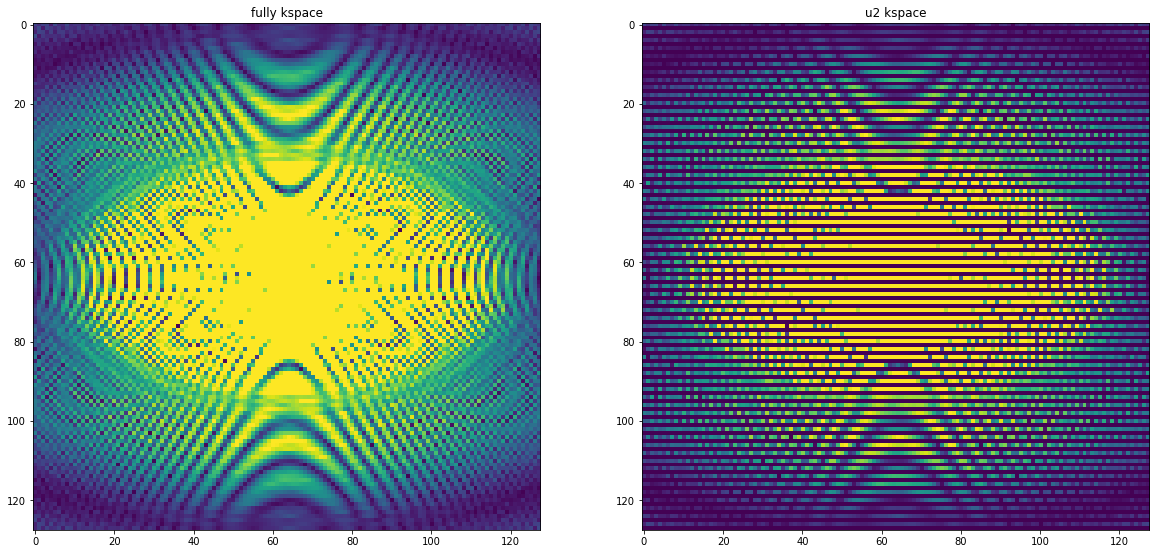

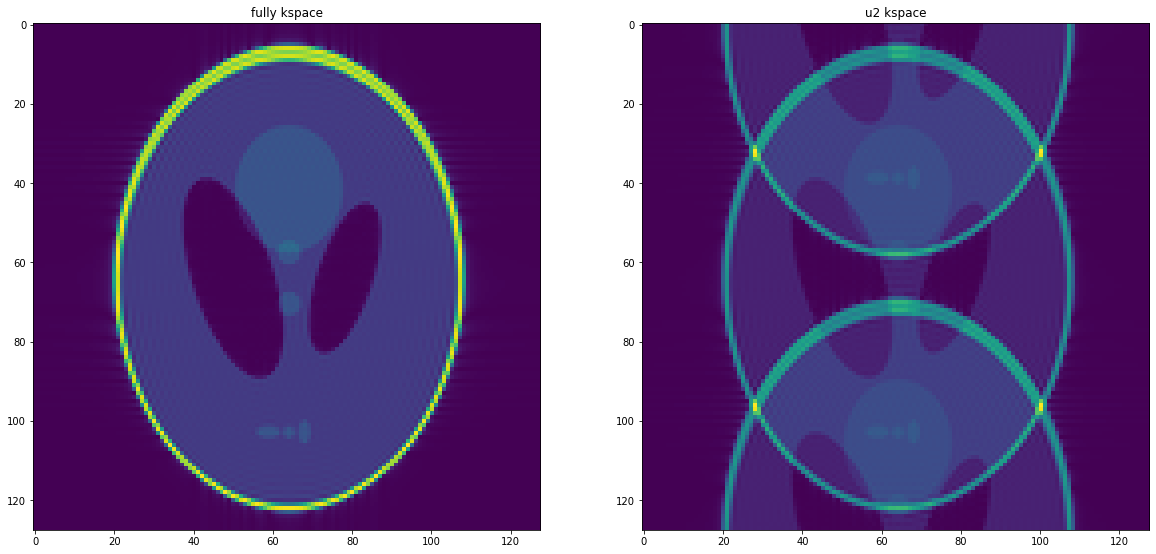

In [38]:
# mettre à 0 une ligne sur 2
shepp_kspace_u2 = np.zeros(shepp_kspace.shape,dtype=complex)
shepp_kspace_u2[0::2,:]=shepp_kspace[0::2,:]

shepp_fft_u2 = bart(1, "fft -i 3", shepp_kspace_u2)

fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
ax[0].set_title("fully kspace")
ax[0].imshow(abs(shepp_kspace),vmin=0, vmax=0.001)

ax[1].set_title("u2 kspace")
ax[1].imshow(abs(shepp_kspace_u2),vmin=0, vmax=0.001)

fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
ax[0].set_title("fully kspace")
ax[0].imshow(abs(shepp_fft))

ax[1].set_title("u2 kspace")
ax[1].imshow(abs(shepp_fft_u2))

# Antennes multiples

In [39]:
!bart phantom -h

Usage: phantom [-s d] [-S d] [-k] [-t <string>] [-G ...] [-T ...] [-N d] [-B ...] [-x d] [-g d] [-3] [-b] [-r d] <output>

Image and k-space domain phantoms.

-s nc      	nc sensitivities
-S nc      	Output nc sensitivities
-k		k-space
-t file      	trajectory
-G		geometric object phantom
-T		tubes phantom
-N num      	Random tubes phantom and number
-B		BART logo
-x n      	dimensions in y and z
-g n=1,2      	select geometry for object phantom
-3		3D
-b		basis functions for geometry
-r seed      	random seed initialization
-h		help


In [105]:
# generation des données

kspace_8ch_no_noise = bart(1,"phantom -k -s 8")
kspace_8ch = bart(1,"noise -n 10000",kspace_8ch_no_noise)
display(np.shape(kspace_8ch))

im_8ch = bart(1,"fft -i 3",kspace_8ch)

(128, 128, 1, 8)

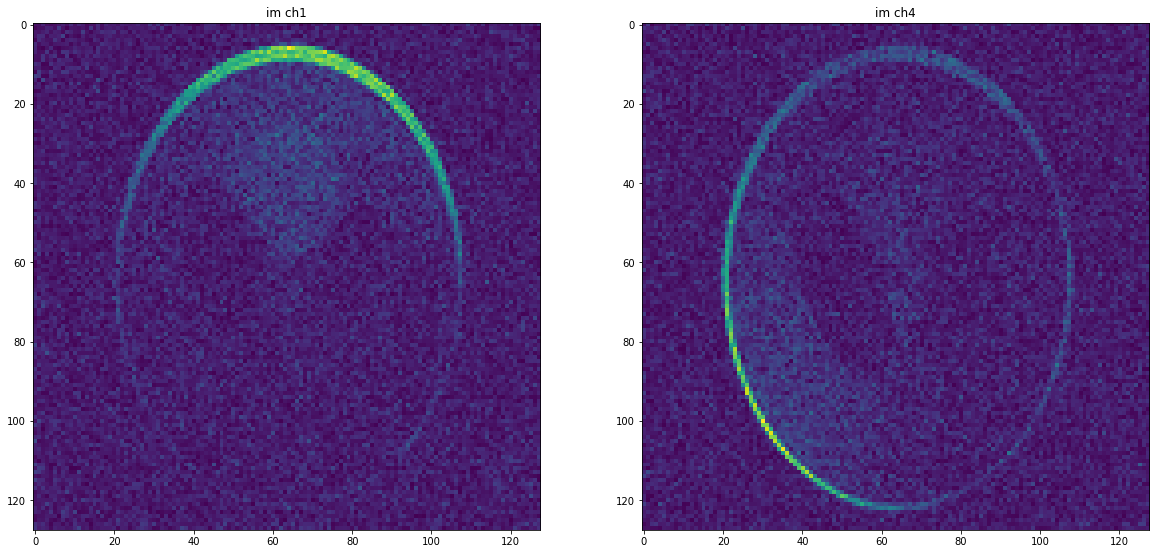

In [100]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
ax[0].set_title("im ch1")
ax[0].imshow(abs(np.squeeze(im_8ch[:,:,:,1])))

ax[1].set_title("im ch4")
ax[1].imshow(abs(np.squeeze(im_8ch[:,:,:,4])))

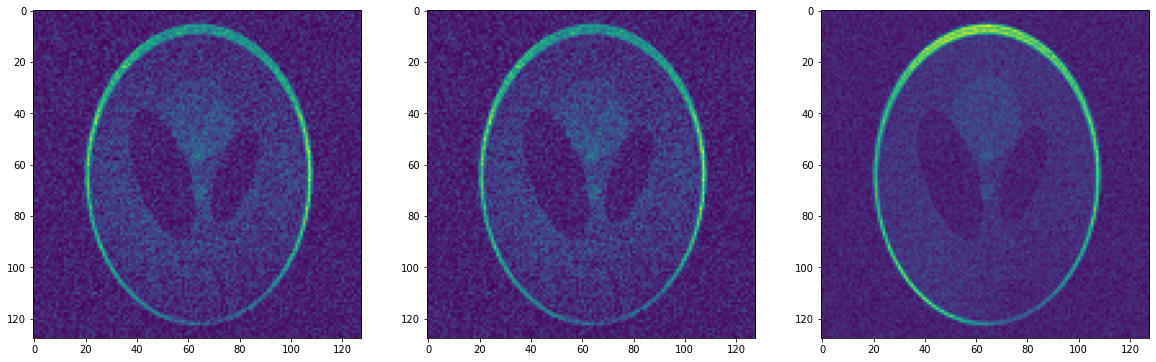

In [101]:
# Somme des k-spaces
k_sum = np.sum(kspace_8ch,axis=3)
im_ksum = bart(1,"fft -i 3",k_sum)

fig, ax = plt.subplots(ncols=3, figsize=(20, 10))
ax[0].imshow(abs(np.squeeze(im_ksum)))

# Somme des im
im_sum = np.sum(im_8ch,axis=3)
ax[1].imshow(abs(np.squeeze(im_sum)))

# Somme des carrés
im_sos = np.sqrt(np.sum(abs(im_8ch)**2,axis=3))
ax[2].imshow(abs(np.squeeze(im_sos)))



In [102]:
# Combinaison idéale -> Calcul carte de sensibilité
!bart caldir -h

Usage: caldir cal_size <input> <output>

Estimates coil sensitivities from the k-space center using
a direct method (McKenzie et al.). The size of the fully-sampled
calibration region is automatically determined but limited by
{cal_size} (e.g. in the readout direction).

-h		help


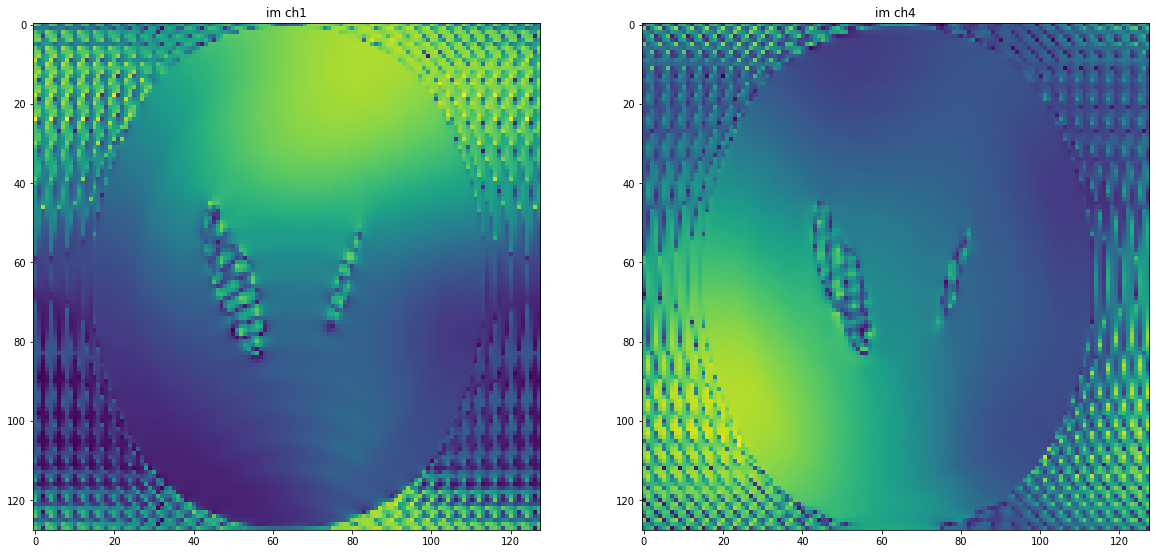

In [106]:
sens = bart(1,"caldir 32",kspace_8ch_no_noise)
fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
ax[0].set_title("im ch1")
ax[0].imshow(abs(np.squeeze(sens[:,:,:,1])))

ax[1].set_title("im ch4")
ax[1].imshow(abs(np.squeeze(sens[:,:,:,4])))

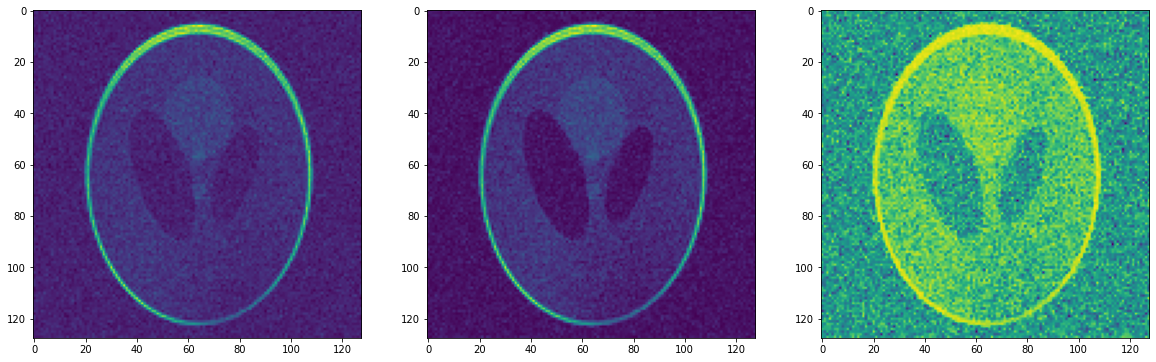

In [107]:
# combinaison idéale
im_sens = 1/np.squeeze(np.sum(abs(sens)**2,axis=3)) * np.squeeze(np.sum(np.conj(sens) * im_8ch,axis=3))

fig, ax = plt.subplots(ncols=3, figsize=(20, 10))
# Somme des carrés
im_sos = np.sqrt(np.sum(abs(im_8ch)**2,axis=3))
ax[0].imshow(abs(np.squeeze(im_sos)))

# sense combinaison
ax[1].imshow(abs(np.squeeze(im_sens)))

# sense combinaison
ax[2].imshow(abs(np.squeeze(im_sens))-abs(np.squeeze(im_sos)))

In [110]:
# play with the noise level 0 / 1000 / 10000 and compare results
!bart noise -h

Usage: noise [-s d] [-r] [-n f] <input> <output>

Add noise with selected variance to input.

-s random seed initialization
-r		real-valued input
-n variance      	DEFAULT: 1.0
-h		help
